In [1]:
%pwd

'/itf-fi-ml/home/arunps/Projects/speaker-type-classifier/notebooks'

In [2]:
import os
os.chdir("../")  # Navigate to project root

In [3]:
%pwd

'/itf-fi-ml/home/arunps/Projects/speaker-type-classifier'

### Imports + paths

In [4]:
from pathlib import Path
import json
import random

import pandas as pd
import numpy as np

import soundfile as sf
import matplotlib.pyplot as plt

from IPython.display import Audio, display


In [5]:
EXPORT_ROOT = Path("/scratch/users/arunps/speaker-type-classifier/data_hf/export/v1")
MANIFEST_PATH = EXPORT_ROOT / "master_manifest_v1.jsonl"

print("Manifest:", MANIFEST_PATH)
print("Exists:", MANIFEST_PATH.exists())


Manifest: /scratch/users/arunps/speaker-type-classifier/data_hf/export/v1/master_manifest_v1.jsonl
Exists: True


### Load manifest jsonl into a DataFrame

In [6]:
rows = []
with open(MANIFEST_PATH, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

df = pd.DataFrame(rows)
df.head()


audio_path       label source  \
0  /scratch/users/arunps/speaker-type-classifier/...  adult_male  vaani   
1  /scratch/users/arunps/speaker-type-classifier/...  adult_male  vaani   
2  /scratch/users/arunps/speaker-type-classifier/...  adult_male  vaani   
3  /scratch/users/arunps/speaker-type-classifier/...  adult_male  vaani   
4  /scratch/users/arunps/speaker-type-classifier/...  adult_male  vaani   

  speaker_id                                               meta  
0       None  {'cfg': 'UttarPradesh_Lucknow', 'language': 'H...  
1       None  {'cfg': 'UttarPradesh_Lucknow', 'language': 'H...  
2       None  {'cfg': 'UttarPradesh_Lucknow', 'language': 'H...  
3       None  {'cfg': 'UttarPradesh_Lucknow', 'language': 'H...  
4       None  {'cfg': 'UttarPradesh_Lucknow', 'language': 'H...

### What does one row look like (raw)

In [7]:
# show 1 raw row
i = 0
print(json.dumps(rows[i], indent=2)[:2000])  # truncation safety


{
  "audio_path": "/scratch/users/arunps/speaker-type-classifier/data_hf/export/v1/adult_male/vaani_UttarPradesh_Lucknow_000000.wav",
  "label": "adult_male",
  "source": "vaani",
  "speaker_id": "None",
  "meta": {
    "cfg": "UttarPradesh_Lucknow",
    "language": "Hindi"
  }
}


### Basic overview

In [8]:
print("Total rows:", len(df))
print("\nColumns:", df.columns.tolist())

print("\nLabel counts:")
print(df["label"].value_counts())

print("\nSource counts:")
print(df["source"].value_counts())


Total rows: 67585

Columns: ['audio_path', 'label', 'source', 'speaker_id', 'meta']

Label counts:
label
adult_male      20000
adult_female    20000
background      14201
child           13384
Name: count, dtype: int64

Source counts:
source
vaani           40000
audioset_20k    14201
audioset_2m     13384
Name: count, dtype: int64


### Check file existence + missing files

In [9]:
df["exists"] = df["audio_path"].apply(lambda p: Path(p).exists())
print("Missing files:", (~df["exists"]).sum())
df[df["exists"] == False].head()


Missing files: 0


Empty DataFrame
Columns: [audio_path, label, source, speaker_id, meta, exists]
Index: []

### Listen to a few samples (random) per class

In [13]:
def listen_random(label, n=3, seed=5678):
    sub = df[df["label"] == label].sample(n=min(n, (df["label"] == label).sum()), random_state=seed)
    for _, r in sub.iterrows():
        p = Path(r["audio_path"])
        print("\nLabel:", r["label"], "| Source:", r["source"])
        print("Path:", p.name)
        display(Audio(str(p)))

listen_random("adult_male", n=2)
listen_random("adult_female", n=2)
listen_random("child", n=2)
listen_random("background", n=2)



Label: adult_male | Source: vaani
Path: vaani_UttarPradesh_Lucknow_009818.wav



Label: adult_male | Source: vaani
Path: vaani_UttarPradesh_Lucknow_019817.wav



Label: adult_female | Source: vaani
Path: vaani_UttarPradesh_Lucknow_009818.wav



Label: adult_female | Source: vaani
Path: vaani_UttarPradesh_Lucknow_019817.wav



Label: child | Source: audioset_2m
Path: audioset_child_Y0K2bbn0PLrE_004019.wav



Label: child | Source: audioset_2m
Path: audioset_child_YQxq_2BfQtyg_000282.wav



Label: background | Source: audioset_20k
Path: audioset_bg_YChgxg1R5kLQ_011969.wav



Label: background | Source: audioset_20k
Path: audioset_bg_YHKU-zmNFSxw_001774.wav


### Compute audio duration for each file 

In [14]:
def get_duration_sec(path):
    try:
        info = sf.info(path)
        return info.frames / info.samplerate
    except Exception:
        return np.nan

# compute durations and show stats
df["duration_sec"] = df["audio_path"].apply(get_duration_sec)

df["duration_sec"].describe()


count    67585.000000
mean         6.479216
std          3.145781
min          0.510875
25%          3.456000
50%          5.692000
75%         10.000000
max         22.524000
Name: duration_sec, dtype: float64

### Duration statistics per class

In [15]:
stats = df.groupby("label")["duration_sec"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
stats


count      mean       std       min        1%        5%  \
label                                                                     
adult_female  20000.0  4.164514  1.717013  1.820000  1.886000  2.110000   
adult_male    20000.0  4.065223  1.628395  1.820000  1.884000  2.096000   
background    14201.0  9.889922  0.666676  0.510875  6.315875  9.507125   
child         13384.0  9.926498  0.436491  1.060875  8.915990  9.553500   

                  50%        95%        99%        max  
label                                                   
adult_female   3.7905   7.530100   9.558669  22.524000  
adult_male     3.7220   7.252050   9.252081  14.742000  
background    10.0000  10.000625  10.001000  10.010750  
child         10.0000  10.000000  10.000687  10.009813

### Plot duration histogram per class (separate plots)

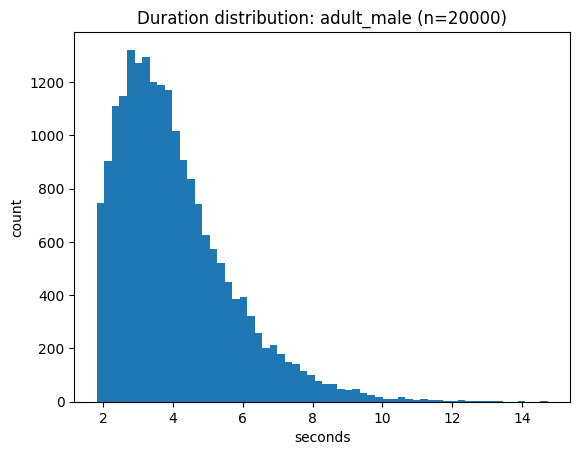

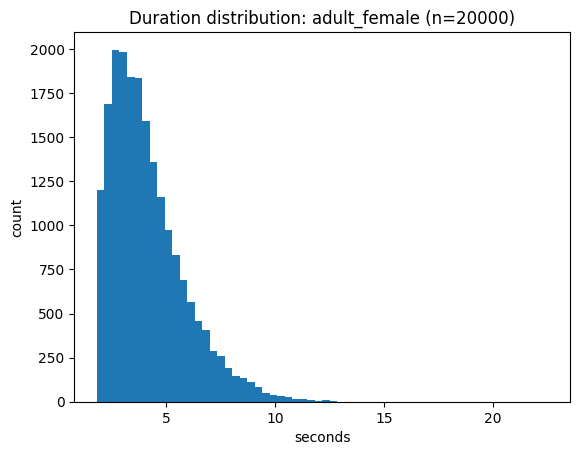

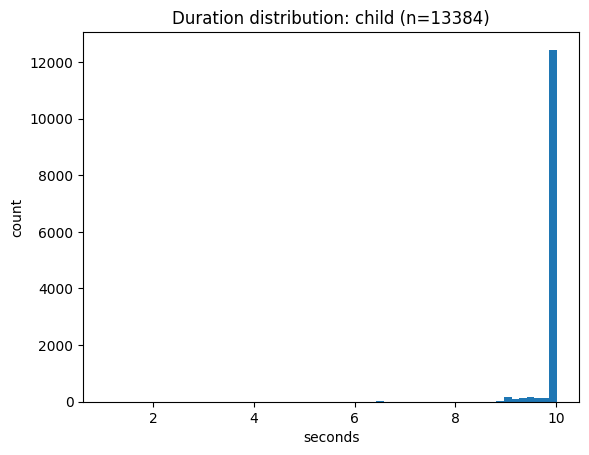

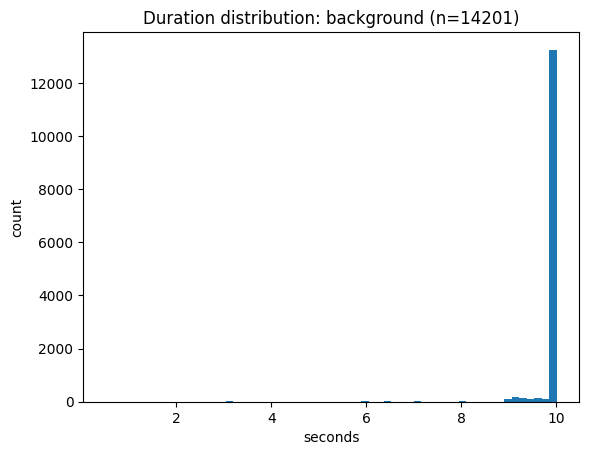

In [16]:
for label in ["adult_male", "adult_female", "child", "background"]:
    sub = df[df["label"] == label]["duration_sec"].dropna()

    plt.figure()
    plt.hist(sub, bins=60)
    plt.title(f"Duration distribution: {label} (n={len(sub)})")
    plt.xlabel("seconds")
    plt.ylabel("count")
    plt.show()


### Find suspiciously short / long clips

In [18]:
SHORT = 0.6   # seconds
LONG  = 20.0  # seconds (AudioSet should be ~10s, Vaani can vary)

print("Very short clips (<0.4s):", (df["duration_sec"] < SHORT).sum())
print("Very long clips  (>20s):", (df["duration_sec"] > LONG).sum())

df[df["duration_sec"] < SHORT].head(10)


Very short clips (<0.4s): 1
Very long clips  (>20s): 1


audio_path       label  \
66332  /scratch/users/arunps/speaker-type-classifier/...  background   

             source speaker_id                                          meta  \
66332  audioset_20k             {'id': 'YcHfPCPrffSQ', 'labels': ['Static']}   

       exists  duration_sec  
66332    True      0.510875

## Listen to the shortest / longest examples (per label)

In [19]:
def listen_extremes(label, n=2, shortest=True):
    sub = df[df["label"] == label].dropna(subset=["duration_sec"]).copy()
    sub = sub.sort_values("duration_sec", ascending=shortest).head(n)

    for _, r in sub.iterrows():
        p = Path(r["audio_path"])
        print("\nLabel:", r["label"], "| Duration:", r["duration_sec"], "| Source:", r["source"])
        print("File:", p.name)
        display(Audio(str(p)))

# shortest
listen_extremes("child", n=2, shortest=True)
listen_extremes("background", n=2, shortest=True)

# longest
listen_extremes("adult_male", n=2, shortest=False)
listen_extremes("adult_female", n=2, shortest=False)



Label: child | Duration: 1.060875 | Source: audioset_2m
File: audioset_child_Y06HoMht81hE_003152.wav



Label: child | Duration: 1.55575 | Source: audioset_2m
File: audioset_child_YbaYVr_NZyr4_009343.wav



Label: background | Duration: 0.510875 | Source: audioset_20k
File: audioset_bg_YcHfPCPrffSQ_012948.wav



Label: background | Duration: 0.7535 | Source: audioset_20k
File: audioset_bg_YSlGOQ8lIESM_006075.wav



Label: adult_male | Duration: 14.742 | Source: vaani
File: vaani_UttarPradesh_Lucknow_004915.wav



Label: adult_male | Duration: 14.544 | Source: vaani
File: vaani_UttarPradesh_Lucknow_018964.wav



Label: adult_female | Duration: 22.524 | Source: vaani
File: vaani_UttarPradesh_Lucknow_005033.wav



Label: adult_female | Duration: 16.7 | Source: vaani
File: vaani_UttarPradesh_Lucknow_005020.wav


### Quick check of sampling rate consistency

In [ ]:
def get_sr(path):
    try:
        return sf.info(path).samplerate
    except Exception:
        return np.nan

df["sr"] = df["audio_path"].apply(get_sr)

print(df["sr"].value_counts().head(10))
print("\nSample rate by label:")
print(df.groupby("label")["sr"].value_counts().head(20))


sr
16000    67585
Name: count, dtype: int64

Sample rate by label:
label         sr   
adult_female  16000    20000
adult_male    16000    20000
background    16000    14201
child         16000    13384
Name: count, dtype: int64


: 